In [ ]:
!module load anaconda3
!activate e1
!pip install numpy
!pip install "monai-weekly[nibabel, tqdm]"
!pip install matplotlib
%matplotlib inline
!pip install nibabel
!pip install SimpleITK
!pip install helpers
!pip install antspyx

!pip install antspynet

/bin/bash: line 1: module: command not found
/bin/bash: line 1: activate: command not found
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.8/18.8 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.2/202.2 kB 4.5 MB/s eta 0:00:00


In [ ]:
# !pip install SimpleITK

import os
import glob
import torch
import time
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader,random_split
from monai.transforms import (
    Compose, LoadImage, EnsureChannelFirst, EnsureType, Orientation, Spacing,
    RandSpatialCrop, RandFlip, NormalizeIntensity, RandScaleIntensity, RandShiftIntensity
)
from monai.networks.nets import SegResNet
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.data import DataLoader, decollate_batch
from monai.inferers import sliding_window_inference
from monai.utils import set_determinism
from monai.config import print_config
from monai.transforms import (
    Activations,
    AsDiscrete,
    EnsureTyped,
    MapTransform,
    AsDiscreted,
    Orientationd,
    Spacingd,
    RandSpatialCropd,
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    EnsureTyped,
    ConvertToMultiChannelBasedOnBratsClassesd,
    Orientationd,
    Spacingd,
    RandSpatialCropd,
    RandFlipd,
    NormalizeIntensityd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    Activations,
    AsDiscrete
)
from torch.utils.data import Subset
import nibabel
import torch.nn.functional as F

In [ ]:
from monai.data import Dataset
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, EnsureTyped

class CustomBraTSDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.data = []
        image_dir = os.path.join(data_dir, "imagesTr")
        label_dir = os.path.join(data_dir, "labelsTr")

        # Collect all patient IDs
        patient_ids = set()
        for filename in os.listdir(image_dir):
            if filename.endswith(".nii.gz"):
                patient_id = filename.split('_')[0]
                patient_ids.add(patient_id)

        for patient_id in patient_ids:
            self.data.append({
                "image": [
                    os.path.join(image_dir, f"{patient_id}_0001.nii.gz"),
                    os.path.join(image_dir, f"{patient_id}_0001.nii.gz"),
                    os.path.join(image_dir, f"{patient_id}_0002.nii.gz"),
                    os.path.join(image_dir, f"{patient_id}_0003.nii.gz")
                ],
                "label": os.path.join(label_dir, f"{patient_id}.nii.gz")
            })
        super().__init__(self.data, transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        if self.transform:
            data = self.transform(data)
        return data

In [ ]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            #Label 1 NEC
            result.append(d[key] == 1)
            #Label 2 SNFH
            result.append(d[key] == 2)
            #Label 3 ET
            result.append(d[key] == 3)
            #Label 4 RC
            result.append(d[key] == 4)
#             # merge label 1 and label 3 to construct TC
#             result.append(torch.logical_or(d[key] == 1, d[key] == 3))
#             # merge label 2, label 1 and label 3 to construct WT
#             result.append(torch.logical_or(torch.logical_or(d[key] == 2, d[key] == 3), d[key] ==1))

            d[key] = torch.stack(result, axis=0).float()
        return d

In [ ]:

train_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[ 182, 218, 182 ], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)

val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)


In [ ]:
root_dir = "nnUNet/nnUNet_raw_2024/Dataset001_GLI"
# root_dir="nnUNet"
full_dataset = CustomBraTSDataset(data_dir=root_dir, transform=None)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Apply transforms to training and validation datasets
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)

In [ ]:
print(full_dataset)

In [ ]:
img,label=train_dataset[0]
print(train_dataset[0]['image'].shape)
print(train_dataset[0]['label'].shape)

torch.Size([4, 182, 218, 182])
torch.Size([4, 182, 218, 182])


image shape: torch.Size([4, 182, 218, 182])


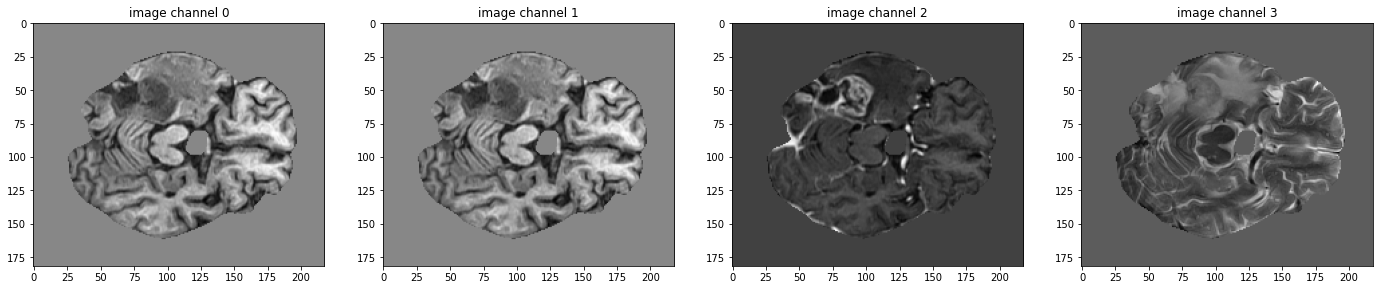

label shape: torch.Size([4, 182, 218, 182])


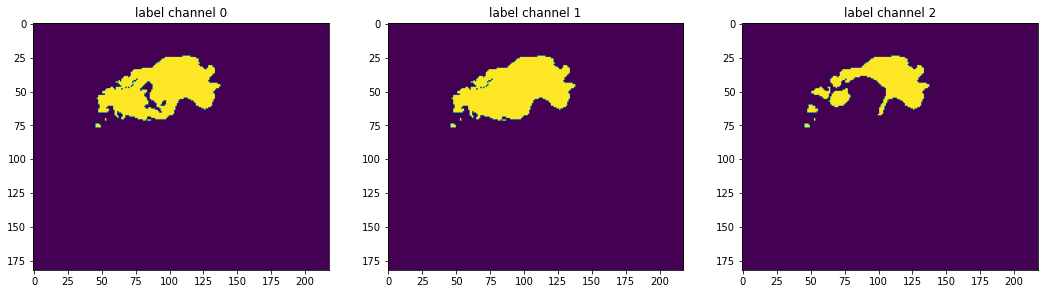

In [ ]:
val_data_example = val_dataset[2]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example["image"][i, :, :, 60].detach().cpu(), cmap="gray")
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(val_data_example["label"][i, :, :, 60].detach().cpu())
plt.show()

In [ ]:
# device = torch.device("cuda:0")
# model = SegResNet(
#     blocks_down=[1, 2, 2, 4],
#     blocks_up=[1, 1, 1],
#     init_filters=16,
#     in_channels=4,
#     out_channels=4,
#     dropout_prob=0.2,
#     spatial_dims=3,
# ).to(device)

# # Test the model with a dummy input
# # input_tensor = torch.randn(1, 4, 182,218,182).to(device)
# # output_tensor = model(input_tensor)
# # print("Output shape:", output_tensor.shape)

In [ ]:
max_epochs = 300
val_interval = 1
VAL_AMP = True

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=4,
    out_channels=3,
    dropout_prob=0.2,
).to(device)
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])


# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(184, 224, 184 ),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

In [ ]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], [], []]
epoch_loss_values = []
metric_values = []
# metric_values_tc = []
# metric_values_wt = []
metric_values_et = []
metric_values_rc = []
metric_values_snfh = []
metric_values_nec = []

total_start = time.time()
for epoch in range(max_epochs):
    print(device)
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs=batch_data["image"].to(device)
        batch_data["image"]=batch_data["image"].detach().cpu()
        labels=batch_data["label"].to(device)
#         inputs, labels = (
#             batch_data["image"].to(device),
#             batch_data["label"].to(device),
#         )
#         print("@,", step)
        batch_data["label"]=batch_data["label"].detach().cpu()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
#             print("outputs", outputs.shape)
#             print("label", inputs.shape)
            pad_sizes = (1, 1, 3, 3, 1, 1)
            resized_tensor = F.pad(inputs, pad_sizes).to(device)
            outputs = model(resized_tensor)
            outputs = outputs[:, :, 1:-1, 3:-3, 1:-1]
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_dataset) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    print("@!")
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_data["image"]=val_data["image"].detach().cpu()
                val_data["label"]=val_data["label"].detach().cpu()
                pad_sizes = (1, 1, 3, 3, 1, 1)
                val_inputs = F.pad(val_inputs, pad_sizes).to(device)
                val_outputs = inference(val_inputs)
                val_outputs = val_outputs[:, :, 1:-1, 3:-3, 1:-1]
#                 val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                val_outputs = [post_trans(i) for i in val_outputs]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()

            metric_nec = metric_batch[0].item()
            metric_values_nec.append(metric_nec)

            metric_snfh = metric_batch[1].item()
            metric_values_snfh.append(metric_snfh)

            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)

            metric_rc = metric_batch[3].item()
            metric_values_rc.append(metric_rc)

            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model(resize img-7/10/24).pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\n nec: {metric_nec:.4f} snfh: {metric_snfh:.4f} et: {metric_et:.4f} rc: {metric_rc:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f"\n at epoch: {best_metric_epoch}"
            )
            with open('metrics_log_(resize img-7/10/24).txt', 'a') as f:
                current_time = time.localtime()
                formatted_time = time.strftime("%Y-%m-%d %H:%M:%S", current_time)
                f.write(f" current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\n nec: {metric_nec:.4f} snfh: {metric_snfh:.4f} et: {metric_et:.4f} rc: {metric_rc:.4f}"
                f"\n best mean dice: {best_metric:.4f}"
                f"\n at epoch: {best_metric_epoch}\n"
                f"\nepoch end time: {formatted_time}\n")
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

cuda:0
----------
epoch 1/300
1/1080, train_loss: 0.9456, step time: 3.4355
2/1080, train_loss: 0.8973, step time: 0.5059
3/1080, train_loss: 0.9697, step time: 0.5042
4/1080, train_loss: 0.9406, step time: 0.5047
5/1080, train_loss: 0.9152, step time: 0.5026
6/1080, train_loss: 0.9657, step time: 0.5034
7/1080, train_loss: 0.9932, step time: 0.5037
8/1080, train_loss: 0.9866, step time: 0.5061
9/1080, train_loss: 0.9230, step time: 0.5024
10/1080, train_loss: 0.9544, step time: 0.5033
11/1080, train_loss: 0.9911, step time: 0.5038
12/1080, train_loss: 0.9839, step time: 0.5063
13/1080, train_loss: 0.9372, step time: 0.5033
14/1080, train_loss: 0.9643, step time: 0.5084
15/1080, train_loss: 0.8698, step time: 0.5049
16/1080, train_loss: 0.9642, step time: 0.5034
17/1080, train_loss: 0.9575, step time: 0.5042
18/1080, train_loss: 0.9963, step time: 0.5063
19/1080, train_loss: 0.9776, step time: 0.5062
20/1080, train_loss: 0.9900, step time: 0.5043
21/1080, train_loss: 0.9993, step time:

In [ ]:
# print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")
with open('metrics_log_(resize img-7/10/24).txt', 'a') as f:
  f.write(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

In [ ]:
print(val_inputs.shape)

In [ ]:
print(inference(val_inputs).shape)

In [ ]:
print(val_outputs.shape)

In [ ]:
import os
import torch
import SimpleITK as sitk
from monai.transforms import Compose, LoadImage, EnsureChannelFirst, EnsureType, Orientation, Spacing, NormalizeIntensity
from monai.inferers import sliding_window_inference
from glob import glob
import nibabel as nib

# Define test transforms (same as validation transforms used during training)
test_transform = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    Orientation(axcodes="RAS"),
    Spacing(pixdim=(1.0, 1.0, 1.0), mode=("bilinear")),
    NormalizeIntensity(nonzero=True, channel_wise=True),
    EnsureType(),
])

# Load the trained model
model = SegResNet(in_channels=4, out_channels=4)  # Modify this if your model architecture differs
model.load_state_dict(torch.load('best_metric_model(resize img-7/10/24).pth'))  # Load your trained model
model.eval()  # Set model to evaluation mode
model.to("cuda" if torch.cuda.is_available() else "cpu")

# def load_patient_data(filepaths):
#     modalities = []
#     for filepath in filepaths:
#         # Load each modality using nibabel
#         nii_data = nib.load(filepath)
#         image_data = nii_data.get_fdata()
#         # Preprocess the image (normalization, resizing if needed, etc.)
#         # Assuming normalization for now
#         image_data = (image_data - image_data.mean()) / image_data.std()
#         # Convert to PyTorch tensor and add batch and channel dimensions
#         modalities.append(torch.tensor(image_data,dtype=torch.float32))
# #         print(shape(modalities))
#     stacked_modalities = torch.cat(modalities, dim=0)
#     return stacked_modalities

# Function to save output images
def save_output(output, patient_id, output_folder):
    for modality_idx in range(output.shape[1]):  # Output shape is [1, 4, 182, 218, 182]
        modality_output = output[0, modality_idx, :, :, :]  # Extract the modality from the output

        # Create output file path for each modality
        output_filepath = os.path.join(output_folder, f"{patient_id}_modality_{modality_idx}.nii.gz")

        # Save using nibabel
        nib.save(nib.Nifti1Image(modality_output.cpu().numpy(), None), output_filepath)
        print(f"Saved modality {modality_idx} for patient {patient_id} at {output_filepath}")

data_folder = 'validation_data'
output_folder = 'monai_validation_outputs_(img resize 7/10/24)'

# Group files by patient based on the prefix (e.g., "02073-100")
files = glob(os.path.join(data_folder, '*.nii*'))
patient_dict = {}

for filepath in files:
    filename = os.path.basename(filepath)
    # Extract patient identifier (assumes the first part is the patient ID)
    patient_id = filename.split('_')[0]
    if patient_id not in patient_dict:
        patient_dict[patient_id] = []
    patient_dict[patient_id].append(filepath)

# Load model (ensure model is in evaluation mode)
# model = SegResNet()
# model.eval()

# Process each patient
with torch.no_grad():
    for patient_id, patient_files in patient_dict.items():
        # Load and preprocess the data for the patient
        patient_data = patient_data.to("cuda" if torch.cuda.is_available() else "cpu").float()
        print(patient_data.shape)
        pad_sizes = (1, 1, 3, 3, 1, 1)
        patient_data = F.pad(inputs, pad_sizes).to(device)
        output = model(patient_data)
        output = output[:, :, 1:-1, 3:-3, 1:-1]

        # Save the model's output
        save_output(output, patient_id, output_folder)

In [ ]:
# updated above